## Reaproveitando LM de acórdãos

Borela - 14/09/2018
Objetivo: Rodar um classificador reaproveitando LM de acórdãos

Dados disponíveis no site: https://contas.tcu.gov.br/pesquisaJurisprudencia/#/pesquisa/jurisprudencia-selecionada

In [1]:
%matplotlib inline
import pandas as pd
from os import listdir
from os.path import isfile, join
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Random permutation of train and test texts
np.random.seed(42)

In [3]:
from fastai.text import *
import html


/home/borela/anaconda3/envs/fastai/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
import spacy
nlp = spacy.load('pt')

In [5]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

## Definindo paths

In [6]:
# set path for classification files
CLAS_PATH=Path('data/tcu/dist_class')
CLAS_PATH.mkdir(exist_ok=True)



In [35]:
# set path for language model files
LM_PATH=Path('data/tcu/dist_lm')
LM_PATH.mkdir(exist_ok=True)
PATH = 'data/tcu/ac'

## Classification data preparation

In [7]:
CLASSES = ['Pessoal', 'Licitação', 'Responsabilidade','Direito_Processual']

## Language model tokenization

In [8]:
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos)})

In [9]:
# pressupostos do vocabulário
assert(stoi['_pad_']==1)
assert(stoi['_unk_']==0)

In [10]:
vs=len(itos)
vs

8603

## Language model treinado em acórdãos

The pre-trained wiki LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target TCU LM so that the weights can be loaded up.

Passo para rexecução 

In [11]:
em_sz,nh,nl = 400,1150,3

PRE_PATH = Path('data/wiki/pt/models/')
PRE_LM_PATH = PRE_PATH/'ptwiki_nandobrbest.h5'
lm_PT_1_cycle_10_epochs_from_scratch

In [12]:
PRE_PATH = Path('/home/borela/modelolinguagemacordao/LmLibText/tmp')
PRE_LM_PATH = PRE_PATH/'lm_1epoca.h5'


In [13]:
PRE_LM_PATH

PosixPath('/home/borela/modelolinguagemacordao/LmLibText/tmp/lm_1epoca.h5')

In [14]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target TCU LM.

In [15]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [16]:
wgts

OrderedDict([('0.encoder.weight', 
              -2.4362e-01  9.8448e-02  8.2343e-02  ...   2.4960e-01 -5.6796e-03  4.6838e-02
              -5.1188e-02 -3.8364e-02 -4.3567e-01  ...  -5.9254e-02  6.2971e-03 -4.7083e-03
               1.6230e-01 -1.4819e-01 -1.3446e-01  ...   3.7861e-02 -1.4444e-01 -1.8709e-01
                              ...                   ⋱                   ...                
              -5.1185e-02 -3.8409e-02 -4.3562e-01  ...  -5.9461e-02  5.4418e-03 -4.7251e-03
              -5.1120e-02 -3.8391e-02 -4.3569e-01  ...  -5.9230e-02  5.9446e-03 -4.3717e-03
              -5.1101e-02 -3.8425e-02 -4.3558e-01  ...  -5.9469e-02  6.3223e-03 -4.6796e-03
              [torch.FloatTensor of size 57567x400]),
             ('0.encoder_with_dropout.embed.weight', 
              -2.4362e-01  9.8448e-02  8.2343e-02  ...   2.4960e-01 -5.6796e-03  4.6838e-02
              -5.1188e-02 -3.8364e-02 -4.3567e-01  ...  -5.9254e-02  6.2971e-03 -4.7083e-03
               1.6230e-01 -1.

In [17]:
itos2 = pickle.load((PRE_PATH/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [18]:
len(itos2)

57567

In [19]:
stoi2['cargo']

4094

In [20]:
stoi['cargo']

86

In [21]:
enc_wgts[stoi2['cargo']]

array([-0.05406, -0.10682, -0.13684,  0.04729, -0.17081,  0.10067,  0.07969,  0.08316,  0.10928, -0.09523,
       -0.09609,  0.07988, -0.02701,  0.05547, -0.0044 ,  0.00164, -0.04653,  0.02699, -0.08813,  0.07403,
       -0.17501,  0.02291,  0.05781, -0.01792,  0.07677, -0.00183,  0.03587,  0.17099, -0.03995, -0.0582 ,
       -0.12001, -0.04285,  0.12813, -0.11678,  0.02031, -0.10737,  0.18531,  0.04181,  0.03314,  0.04069,
        0.02321, -0.03589,  0.02847,  0.1163 ,  0.02538, -0.09682,  0.07854,  0.00813, -0.05809, -0.03296,
        0.07301,  0.13031,  0.09603, -0.01998, -0.1144 ,  0.0571 , -0.22418, -0.05606, -0.04296, -0.01443,
        0.12083,  0.05386, -0.00277, -0.03233, -0.13574, -0.08797,  0.01036,  0.00046,  0.16372,  0.10024,
       -0.02981, -0.00706,  0.10422, -0.15235, -0.05361, -0.15311, -0.04882, -0.1499 ,  0.10566, -0.00029,
       -0.04939,  0.05636,  0.01247, -0.09659, -0.07416,  0.02241,  0.0644 , -0.1348 ,  0.05603, -0.03074,
        0.0495 , -0.03736, -0.00382, 

Before we try to transfer the knowledge from wikitext to the TCU LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown Senado tokens that do not exist in ptwiki_nandobr.

Alterei código abaixo para saber qtds (Borela)

In [22]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
qtd_ausente = 0
for i,w in enumerate(itos):
    r = stoi2[w]
    if r>=0:
        new_w[i] = enc_wgts[r]  
    else:
        new_w[i] = row_m
        #print('palavra não havia na wiki', i, w, freq[w])
        print('palavra não havia no modelo reaproveitado', i, w)
        qtd_ausente += 1
print('qtd ausente:', qtd_ausente)

palavra não havia no modelo reaproveitado 12 xfld
palavra não havia no modelo reaproveitado 485 ”
palavra não havia no modelo reaproveitado 509 “
palavra não havia no modelo reaproveitado 1007 –
palavra não havia no modelo reaproveitado 1647 ‘
palavra não havia no modelo reaproveitado 1916 p><p
palavra não havia no modelo reaproveitado 2364 dsic
palavra não havia no modelo reaproveitado 2417 gsipr
palavra não havia no modelo reaproveitado 2446 montepio
palavra não havia no modelo reaproveitado 2480 in01
palavra não havia no modelo reaproveitado 2563 27.002
palavra não havia no modelo reaproveitado 2621 i>.
palavra não havia no modelo reaproveitado 2858 9.030
palavra não havia no modelo reaproveitado 3094 3.738
palavra não havia no modelo reaproveitado 3442 combatentes
palavra não havia no modelo reaproveitado 3678 dai
palavra não havia no modelo reaproveitado 3694 4.242
palavra não havia no modelo reaproveitado 3917 

palavra não havia no modelo reaproveitado 3986 27002
palavra não hav

300 (3%) palavras ausentes: xfld, montepio, assinam, etc
(Anotação de Borela)

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [24]:
??T

Coloquei cuda=False para não dar erro de memória

In [26]:
T(new_w, cuda=False)


-2.4362e-01  9.8448e-02  8.2343e-02  ...   2.4960e-01 -5.6796e-03  4.6838e-02
-5.1188e-02 -3.8364e-02 -4.3567e-01  ...  -5.9254e-02  6.2971e-03 -4.7083e-03
-5.4711e-02  2.2545e-02 -1.9539e-01  ...   8.2766e-02 -3.8843e-02  7.3945e-02
                ...                   ⋱                   ...                
-1.6831e-01 -1.1835e-02 -4.7351e-01  ...  -8.5141e-02  2.7722e-02 -7.8397e-03
-7.7045e-02 -5.8913e-02 -4.7609e-01  ...  -4.5969e-02  2.0786e-02 -2.5464e-02
-1.1505e-01  3.8582e-02 -4.8247e-01  ...  -1.3447e-01 -2.4166e-02  7.1570e-02
[torch.FloatTensor of size 8603x400]

In [29]:
wgts['0.encoder.weight'] = T(new_w) #, cuda=False)


Now that we have the weights prepared, we are ready to create and start training our new TCU language pytorch model!

In [30]:
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w)) # , cuda=False)
wgts['1.decoder.weight'] = T(np.copy(new_w)) #, cuda=False)

## TCU Language model

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the Senado LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

Passo para rexecução 

In [31]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

Passo para rexecução 

In [33]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')

In [34]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)

In [36]:
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

Parâmetro a variar: 0.7 (Borela)

In [37]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [38]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [42]:
for name, param in wgts.items():
    print(name, param)

0.encoder.weight 
-2.4362e-01  9.8448e-02  8.2343e-02  ...   2.4960e-01 -5.6796e-03  4.6838e-02
-5.1188e-02 -3.8364e-02 -4.3567e-01  ...  -5.9254e-02  6.2971e-03 -4.7083e-03
-5.4711e-02  2.2545e-02 -1.9539e-01  ...   8.2766e-02 -3.8843e-02  7.3945e-02
                ...                   ⋱                   ...                
-1.6831e-01 -1.1835e-02 -4.7351e-01  ...  -8.5141e-02  2.7722e-02 -7.8397e-03
-7.7045e-02 -5.8913e-02 -4.7609e-01  ...  -4.5969e-02  2.0786e-02 -2.5464e-02
-1.1505e-01  3.8582e-02 -4.8247e-01  ...  -1.3447e-01 -2.4166e-02  7.1570e-02
[torch.cuda.FloatTensor of size 8603x400 (GPU 0)]

0.encoder_with_dropout.embed.weight 
-2.4362e-01  9.8448e-02  8.2343e-02  ...   2.4960e-01 -5.6796e-03  4.6838e-02
-5.1188e-02 -3.8364e-02 -4.3567e-01  ...  -5.9254e-02  6.2971e-03 -4.7083e-03
-5.4711e-02  2.2545e-02 -1.9539e-01  ...   8.2766e-02 -3.8843e-02  7.3945e-02
                ...                   ⋱                   ...                
-1.6831e-01 -1.1835e-02 -4.7351e-01 

In [49]:
learner.model

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(8603, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(8603, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=8603, bias=False)
    (dropout): LockedDropout(
    )
  )
)

Usei parm strict=False

In [52]:
learner.model.load_state_dict(wgts,strict=False)

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [53]:
lr=1e-3
lrs = lr

In [54]:
%%time
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      4.364745   4.092917   0.304695  

CPU times: user 1min 4s, sys: 26.4 s, total: 1min 30s
Wall time: 1min 30s


[array([4.09292]), 0.3046946666742626]

In [58]:
!pwd

/home/borela/svnview/ServicosCognitivos/Fontes/ClassifJurisprudencia/nlp-tcu-enunciados-master


Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [59]:
learner.save('/home/borela/svnview/ServicosCognitivos/Fontes/ClassifJurisprudencia/nlp-tcu-enunciados-master/'+PATH+'/lm_last_ft')

In [60]:
learner.load('/home/borela/svnview/ServicosCognitivos/Fontes/ClassifJurisprudencia/nlp-tcu-enunciados-master/'+PATH+'/lm_last_ft')

In [61]:
learner.unfreeze()

In [62]:
%%time
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.754507   3.572962   0.336865  

CPU times: user 1min 29s, sys: 36 s, total: 2min 5s
Wall time: 2min 5s


In [65]:
print('Perplexidade = ', np.exp(3.57))

Perplexidade =  35.51659315162847


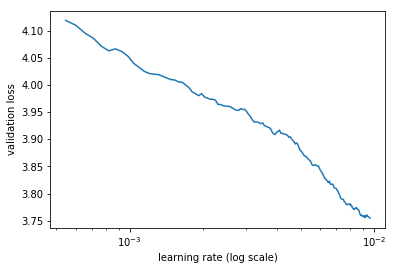

In [66]:
learner.sched.plot()

In [68]:
lr=0.01
lrs = lr

In [69]:
%%time
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.681597   3.482576   0.350882  
    1      3.464359   3.34912    0.362991                   
    2      3.272      3.24565    0.375739                   
    3      3.139743   3.183317   0.383339                   
    4      3.027907   3.152532   0.391752                   
    5      2.913521   3.089938   0.400682                   
    6      2.84061    3.035818   0.4102                     
    7      2.734552   2.996945   0.41541                    
    8      2.611044   2.952095   0.42732                    
    9      2.528403   2.903243   0.435483                   
    10     2.478574   2.861792   0.441412                   
    11     2.373513   2.8681     0.446708                   
    12     2.291196   2.828873   0.455242                   
    13     2.194889   2.815135   0.457353                   
    14     2.112274   2.792512   0.462792                   

CPU times: user 22min 52s, sys: 9min 15s

[array([2.79251]), 0.46279198715561315]

In [70]:
learner.save('/home/borela/svnview/ServicosCognitivos/Fontes/ClassifJurisprudencia/nlp-tcu-enunciados-master/'+PATH+'/lm1')

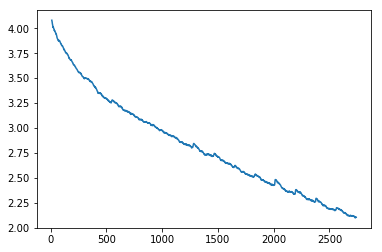

In [71]:
learner.sched.plot_loss()

<function matplotlib.pyplot.show>

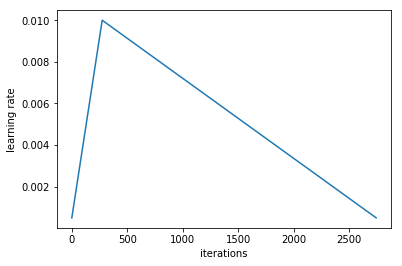

In [73]:
import matplotlib.pyplot as plt
plt.xlabel("iterations")
plt.ylabel("learning rate")
plt.plot(learner.sched.iterations, learner.sched.lrs)
plt.show

In [60]:
learner.load('/home/borela/svnview/ServicosCognitivos/Fontes/ClassifJurisprudencia/nlp-tcu-enunciados-master/'+PATH+'/lm1')

In [74]:
%%time
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=10)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.447393   2.984392   0.423587  
    1      2.77669    3.083495   0.405871                   
    2      2.733096   3.072663   0.412765                   
    3      2.684891   3.029864   0.419463                   
    4      2.582161   3.002245   0.426122                   
    5      2.469037   2.954882   0.435754                   
    6      2.419381   2.927266   0.44127                    
    7      2.292025   2.909691   0.44745                    
    8      2.224302   2.874266   0.455145                   
    9      2.133004   2.862774   0.458455                   

CPU times: user 15min 16s, sys: 6min 10s, total: 21min 26s
Wall time: 21min 25s


[array([2.86277]), 0.4584547736142811]

In [75]:
learner.save('/home/borela/svnview/ServicosCognitivos/Fontes/ClassifJurisprudencia/nlp-tcu-enunciados-master/'+PATH+'/lm1b')

In [60]:
learner.load('/home/borela/svnview/ServicosCognitivos/Fontes/ClassifJurisprudencia/nlp-tcu-enunciados-master/'+PATH+'/lm1b')

In [76]:
print('Perplexidade = ', np.exp(2.86))

Perplexidade =  17.46152693657999


In [77]:
ss="""o cargo em comissão de consultor jurídico dos ministérios é de livre """
s = [Tokenizer().spacy_tok(ss)]
#print(s)
#t=stoi[s]
textoaux=' '.join(s[0])
print(textoaux)
tabnum=[]
for it in s[0]:
   tabnum.append(stoi[it])
   print(it, stoi[it])
print(tabnum)
print([itos[o] for o in tabnum])

o cargo em comissão de consultor jurídico dos ministérios é de livre
o 6
cargo 86
em 15
comissão 259
de 2
consultor 5152
jurídico 293
dos 26
ministérios 6601
é 27
de 2
livre 2146
[6, 86, 15, 259, 2, 5152, 293, 26, 6601, 27, 2, 2146]
['o', 'cargo', 'em', 'comissão', 'de', 'consultor', 'jurídico', 'dos', 'ministérios', 'é', 'de', 'livre']


In [104]:
def what_next(seq, res_len):
    m = learner.model
    # Turn off dropout
    m.eval() # não fez diferença no teste
    # Reset hidden state
    m.reset()  
    tok = Tokenizer().proc_text(seq)
    ids = [stoi[word] for word in tok]
    # print('stoi:', ids, end='\n\n')

    """ deveria mostrar próximas 15 palavras candidatas, mas precisa ser revisto
    proxima_palavra = []
    res,*_ = m(V(T(np.array([ids]))))
    [proxima_palavra.append(itos[o]) for o in to_np(torch.topk(res[-1], 15)[1])]
    print('15 candidatas a proxima_palavra ', proxima_palavra, end='\n\n')
    """
    
    res = []
    for i in ids:
        x = V(np.array(i)).unsqueeze(0)
        preds =m(x)
        val,idx = preds[0].data.max(1)
    for i in range(res_len):
        res.append(idx[0])
        x = V(idx).unsqueeze(0)
        preds = m(x)
        val,idx = preds[0].data.max(1)
    return [itos[i] for i in res]


In [105]:
s="""o cargo em comissão de consultor jurídico dos ministérios é de livre """
print(what_next(s, 12))

stoi: [6, 86, 15, 259, 2, 5152, 293, 26, 6601, 27, 2, 2146]

['nomeação', ',', 'não', 'sendo', 'possível', 'estender', 'o', 'servidor', 'cedido', '.', '\n', 'xbos']


In [87]:
s="""o cargo em comissão de consultor jurídico dos ministérios é de livre """
print(what_next(s, 15))

stoi: [6, 86, 15, 259, 2, 5152, 293, 26, 6601, 27, 2, 2146]

['nomeação', ',', 'não', 'sendo', 'possível', 'estender', 'o', 'servidor', 'cedido', '.', '\n', 'xbos', 'xfld', '1', 'a']


(versão original Fernando)
%%time
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)


HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))
epoch      trn_loss   val_loss   accuracy                   
    0      4.346938   3.863956   0.318073  
    1      3.889904   3.513234   0.352266                   
    2      3.614359   3.316463   0.372923                   
    3      3.432717   3.182624   0.387281                   
    4      3.299603   3.090508   0.398573                   
    5      3.19458    3.022937   0.406933                   
    6      3.111347   2.963846   0.415421                   
    7      3.024716   2.917209   0.421194                   
    8      2.976804   2.882251   0.426415                   
    9      2.932255   2.848631   0.431315                   
    10     2.877682   2.828991   0.43471                    
    11     2.862214   2.810855   0.437535                   
    12     2.830114   2.798963   0.439408                   
    13     2.783524   2.792671   0.440428                   
    14     2.782638   2.786632   0.441947                   

CPU times: user 7min 21s, sys: 1min 38s, total: 9min
Wall time: 9min
[array([2.78663]), 0.44194654571382624]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [107]:
learner.save_encoder('/home/borela/svnview/ServicosCognitivos/Fontes/ClassifJurisprudencia/nlp-tcu-enunciados-master/'+PATH+'/lm1b_enc')

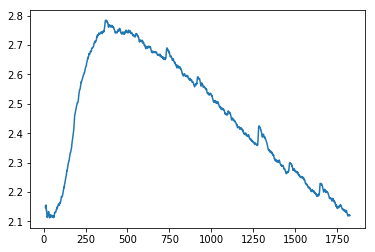

In [108]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

In [109]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [110]:
len(tok_trn), len(tok_val)

(9236, 1027)

In [111]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [112]:
trn_clas

array([list([10, 11, 12, 9, 4, 287, 133, 2, 85, 740, 3, 4, 6, 2958, 1029, 24, 6, 227, 49, 51, 3, 24, 571, 2, 1949, 76, 292, 71, 3, 331, 599, 4, 6, 284, 7, 415, 2, 518, 45, 13, 4, 612, 2, 131, 768, 40, 213, 22, 402, 5]),
       list([10, 11, 12, 9, 4, 155, 2, 94, 327, 2, 813, 257, 18, 393, 2, 149, 2, 342, 84, 1669, 36, 1644, 40, 90, 39, 33, 3154, 3, 410, 15, 320, 14, 36, 716, 193, 3163, 17, 541, 13, 193, 3288, 17, 541, 3, 3341, 8, 968, 3, 4, 6, 7062, 4, 408, 18, 96, 14, 6644, 3, 31, 119, 7, 63, 3, 104, 111, 4836, 3562, 3, 6645, 6643, 4, 78, 2, 238, 128, 21, 84, 2, 149, 1821, 29, 1035, 2, 813, 257, 5]),
       list([10, 11, 12, 9, 4, 455, 2, 201, 2, 580, 18, 908, 2, 50, 31, 44, 71, 51, 35, 32, 5, 887, 7, 28, 188, 17, 166, 34, 64, 33, 656, 343, 25, 97, 14, 3, 611, 16, 185, 4711, 7, 50, 3, 5279, 18, 4362, 6, 190, 5]),
       ...,
       list([10, 11, 12, 9, 27, 365, 4, 78, 2, 254, 3, 24, 99, 31, 28, 193, 1953, 17, 2339, 3, 4, 96, 4074, 2218, 4, 6, 125, 7, 20, 1946, 5, 238, 128, 104, 2119, 

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained IMDB backbone. The steps to create the classifier model are similar to the ones for the LM.

trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [113]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

no LM usou bs = 52 (Borela)
optim.Adam...
Variar

In [114]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 12

Pegando intervalo de números das classes (Borela)

In [115]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [116]:
min_lbl, c

(0, 4)

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [117]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

?? Não entendi  2 linhas abaixo (Borela)

In [118]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

Passo para rexecução 

In [118]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

Passo para rexecução 

In [119]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

Passo para rexecução 

In [120]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

Passo para rexecução 

In [121]:
learn_clas = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn_clas.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn_clas.clip=25.
learn_clas.metrics = [accuracy]

Passo para rexecução 

In [122]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [123]:
print(lrs)

[0.00007 0.00017 0.00044 0.00115 0.003  ]


antes tinha esse comsndo sbrepondo: 
  lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [129]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [126]:
wd = 1e-7
wd = 0
learn_clas.load_encoder('/home/borela/svnview/ServicosCognitivos/Fontes/ClassifJurisprudencia/nlp-tcu-enunciados-master/'+PATH+'/lm1b_enc')

In [127]:
learn_clas.freeze_to(-1)

In [130]:
learn_clas.lr_find(lrs/1000)


RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/csrc/generic/serialization.cpp:38

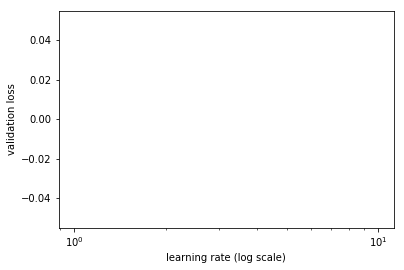

In [131]:
learn_clas.sched.plot()

??? Mudar lr para 5 10 -1 (Borela)  

Rodamos o find e não alteramos rl depois ??

In [132]:
%%time
learn_clas.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCTensorMath.cu:26

In [168]:
learn.save('clas_0')

In [169]:
learn.load('clas_0')

In [170]:
learn.freeze_to(-2)

In [133]:
%%time
learn_clas.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCTensorMath.cu:26

In [172]:
learn.save('clas_1')

Passos para rexecução 

In [31]:
learn.load('clas_1')

In [32]:
learn.unfreeze()

Estava 24...
Reduzi para 16 (Borela)
variar

In [44]:
bs=8

# em caso de reexecução após load clas_1

em_sz=400 
nh = 1150 
nl=3
bptt=70
bs=4    # estourou memória out of memory : 16, 52
wd=1e-7
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)


drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.3

learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]

In [47]:
%%time
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.322043   0.252854   0.907498  
    1      0.31987    0.253344   0.907498                    
    2      0.259365   0.190088   0.932814                    
    3      0.211837   0.166373   0.937683                    
    4      0.177007   0.168213   0.936709                    
    5      0.181295   0.156022   0.94742                     
    6      0.141055   0.150935   0.950341                    
    7      0.122673   0.148351   0.950341                    
    8      0.0851     0.15148    0.953262                     
    9      0.082571   0.139516   0.952288                     
    10     0.102657   0.146887   0.950341                     
    11     0.079494   0.142091   0.948393                     
    12     0.088254   0.137891   0.952288                     
    13     0.077607   0.141387   0.953262                     

CPU times: user 27min 29s, sys: 11min 50s, total: 39min 19s
Wall time: 39min 16s


[array([0.14139]), 0.9532619302089398]

<function matplotlib.pyplot.show>

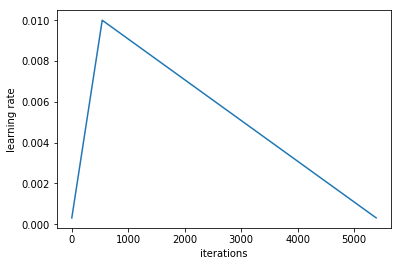

In [49]:
import matplotlib.pyplot as plt
plt.xlabel("iterations")
plt.ylabel("learning rate")
plt.plot(learn.sched.iterations, learn.sched.lrs)
plt.show

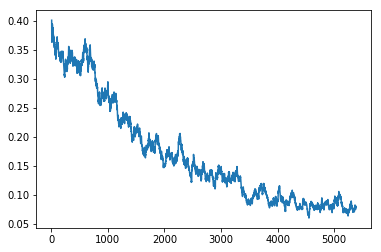

In [56]:
learn.sched.plot_loss()

In [57]:
%%time
learn.fit(lrs, 1, wds=wd, cycle_len=7, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.100518   0.169843   0.951315  
    1      0.097744   0.153804   0.952288                     
    2      0.107056   0.156666   0.950341                     
    3      0.06696    0.156495   0.951315                     
    4      0.051846   0.162881   0.951315                     
    5      0.064159   0.136796   0.95813                      
    6      0.050371   0.14782    0.95813                      

CPU times: user 13min 4s, sys: 5min 39s, total: 18min 44s
Wall time: 18min 42s


[array([0.14782]), 0.9581304775240823]

In [58]:
learn.save('clas_2')

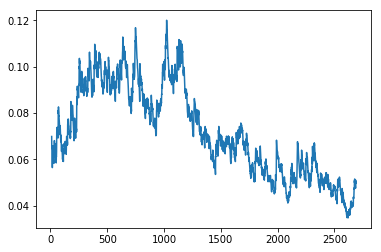

In [59]:
learn.sched.plot_loss()

The previous state of the art result was 94.1% accuracy (5.9% error). With bidir we get 95.4% accuracy (4.6% error).

## End